# ORIE 4580/5580/5581 Assignment 3

#### Students: Raymond Tao (st2242) and Xiaotong Tan (xt254)

### Github link: [HW3](https://github.com/raymondtaj/orie5580/blob/main/HW3/HW3.ipynb)

(**Please replace this with your own link!**)

### Instructions


* Due Thursday September 25, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [1]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

<hr><hr>

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats\ldots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) \mbox{ mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) \mbox{ mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) \mbox{ mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


<hr>

**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).

<hr>

In [2]:
# Functions to visualize LCG sequence on clock (see demo notebook)


def plot_clock_face(m, ax=None, annotate=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4), dpi=120)
    theta = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta))
    angs = 2*np.pi*np.arange(m)/m
    ax.scatter(np.cos(angs), np.sin(angs), s=30)
    if annotate:
        for k, a in enumerate(angs):
            ax.text(np.cos(a)*1.08, np.sin(a)*1.08, str(k), ha="center", va="center")
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    return ax

def plot_clock_path(states, m, ax=None):
    """Draw directed steps for the given integer states (mod m)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4), dpi=120)
    ang = 2*np.pi*np.array(states)/m
    xs, ys = np.cos(ang), np.sin(ang)
    for i in range(len(states)-1):
        ax.arrow(xs[i], ys[i], xs[i+1]-xs[i], ys[i+1]-ys[i],
                 length_includes_head=True, head_width=0.05, head_length=0.08)
    ax.scatter(xs, ys)
    ax.set_aspect('equal', 'box'); ax.axis('off')
    return ax





In [3]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (see demo notebook)
def lcg_states(n, a, m, c=0, seed=1):
    """Return first n integer states (x0 included) for x_{k+1}=(a x_k + c) mod m."""
    out = np.empty(n, dtype=int)
    x = seed
    for i in range(n):
        out[i] = x
        x = (a*x + c) % m
    return out


x_n (mod 16): [1, 5, 9, 13, 1, 5, 9, 13, 1, 5, 9, 13] period: 4
y_n (mod 7):  [1, 2, 4, 1, 2, 4, 1, 2, 4, 1, 2, 4] period: 3


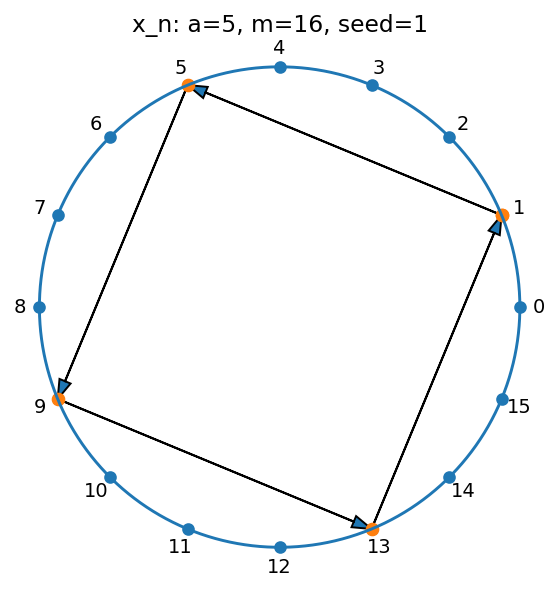

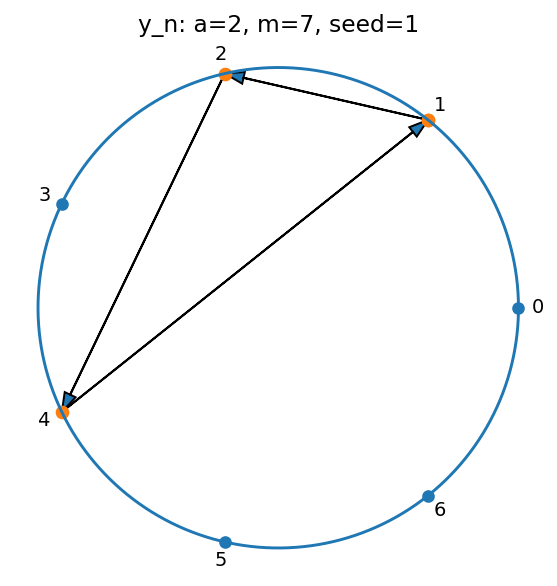

In [4]:
# Ans
# Two LCGs: x_{n+1}=(5 x_n) mod 16,  y_{n+1}=(2 y_n) mod 7,  x0=y0=1
x = lcg_states(12, a=5, m=16, seed=1)   # a few repeats to show the cycle
y = lcg_states(12, a=2, m=7,  seed=1)

def period_from_seed(states, seed=1):
    for t in range(1, len(states)):
        if states[t] == seed:
            return t
    return None

px, py = period_from_seed(x, 1), period_from_seed(y, 1)
print("x_n (mod 16):", x.tolist(), "period:", px)
print("y_n (mod 7): ", y.tolist(), "period:", py)

fig1, ax1 = plt.subplots(figsize=(5,5), dpi=140)
plot_clock_face(16, ax1, annotate=True)
plot_clock_path(x[:px+1], 16, ax1)  # one full cycle + return
ax1.set_title("x_n: a=5, m=16, seed=1")

fig2, ax2 = plt.subplots(figsize=(5,5), dpi=140)
plot_clock_face(7, ax2, annotate=True)
plot_clock_path(y[:py+1], 7, ax2)   # one full cycle + return
ax2.set_title("y_n: a=2, m=7, seed=1")
plt.show()


<hr>

**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.

<hr>

z_n (mod 16): [2, 7, 13, 14, 3, 9, 10, 15, 5, 6, 11, 1, 2, 7, 13, 14, 3, 9, 10, 15]
Detected period of z_n: 12


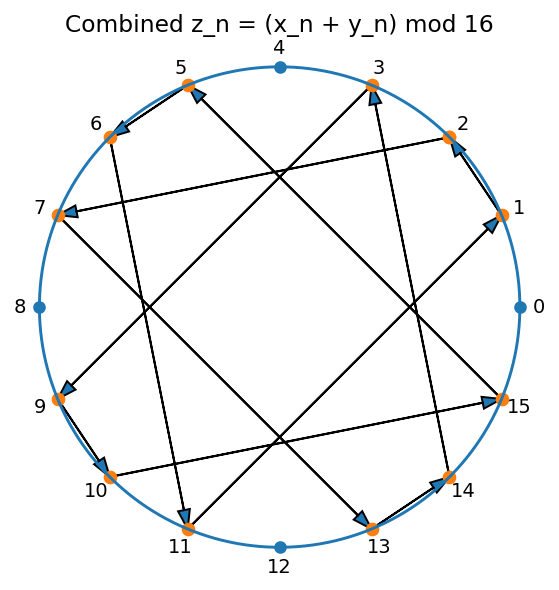

In [5]:

x = lcg_states(40, a=5, m=16, seed=1)  
y = lcg_states(40, a=2, m=7,  seed=1)   


z = (x + y) % 16


def detect_period(states, seed):
    for t in range(1, len(states)):
        if states[t] == seed:
            return t
    return None

pz = detect_period(z, z[0])
print("z_n (mod 16):", z[:max(20, pz+2)].tolist())
print("Detected period of z_n:", pz)

fig, ax = plt.subplots(figsize=(5,5), dpi=140)
plot_clock_face(16, ax, annotate=True)
plot_clock_path(z[:pz+1], 16, ax)  
ax.set_title("Combined z_n = (x_n + y_n) mod 16")
plt.show()


___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.


For $x_n$:

$$
x_{n+1} = (5x_n) \bmod 16, \quad x_0 = 1
$$

The sequence repeats after 4 steps, since

$$
5^4 \equiv 1 \pmod{16}.
$$

Period = 4


For $y_n$:

$$
y_{n+1} = (2y_n) \bmod 7, \quad y_0 = 1
$$

The sequence repeats after 3 steps, since

$$
2^3 \equiv 1 \pmod{7}.
$$

Period = 3


For the combined generator $z_n$:

$$
z_n = (x_n + y_n) \bmod 16
$$

The period is the least common multiple of the two base periods:

$$
\text{lcm}(4,3) = 12.
$$

Period = 12


___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___

### Ans.
**Ans.**

The cdf is
$$
F(x)=
\begin{cases}
0, & x<0,\\[2pt]
x, & 0\le x<\tfrac12,\\[2pt]
\tfrac12, & \tfrac12\le x<1,\\[2pt]
1, & x\ge 1.
\end{cases}
$$

Using the pseudoinverse
$$
F^{-1}(y)\;=\;\inf\{x:\,F(x)\ge y\},
$$
we obtain
$$
F^{-1}(y)=
\begin{cases}
y, & 0< y\le \tfrac12,\\[4pt]
1, & \tfrac12< y\le 1,
\end{cases}
\qquad\text{and commonly set }F^{-1}(0)=0.
$$

At $y=\tfrac12$ the infimum is $x=\tfrac12$ since $F(x)=\tfrac12$ for all $x\in[\tfrac12,1)$


___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

First 20 samples: [3, 2, 4, 3, 1, 7, 3, 3, 1, 2, 1, 5, 2, 4, 2, 1, 2, 1, 4, 2]
Empirical mean = 2.364,  Theoretical mean = 2.381
Empirical var  = 3.237,  Theoretical var  = 3.288


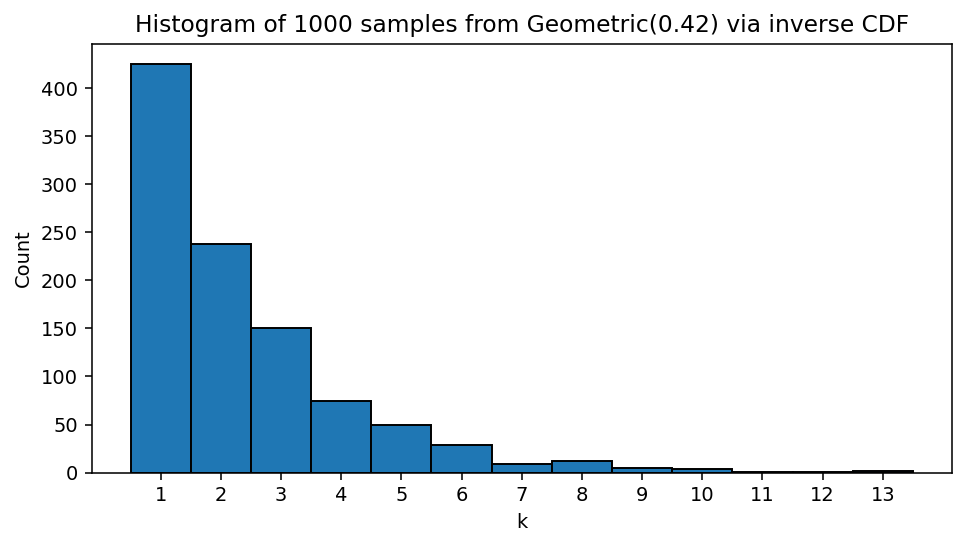

In [6]:


def geom_inv_cdf(u, p):
    """
    Vectorized inverse CDF for Geometric(p) with support {1,2,...}.
    u: array of Uniform(0,1) variates in (0,1).
    Returns integer samples.
    """
    u = np.asarray(u)
    # F(k) = 1 - (1-p)^k  =>  k = ceil( log(1-u) / log(1-p) )
    # guard against u=0 exactly
    eps = np.finfo(float).eps
    k = np.ceil(np.log1p(-np.clip(u, eps, 1 - eps)) / np.log1p(-p)).astype(int)
    return k

# Generate 1000 samples from Geometric(0.42)
rng = np.random.default_rng(42)
u = rng.random(1000)
samples = geom_inv_cdf(u, p=0.42)

# Basic stats
p = 0.42
theo_mean = 1/p
theo_var = (1-p)/(p**2)
emp_mean = samples.mean()
emp_var = samples.var(ddof=1)

print("First 20 samples:", samples[:20].tolist())
print(f"Empirical mean = {emp_mean:.3f},  Theoretical mean = {theo_mean:.3f}")
print(f"Empirical var  = {emp_var:.3f},  Theoretical var  = {theo_var:.3f}")

# Plot histogram (counts) for the 1000 samples
max_k = samples.max()
bins = np.arange(1, max_k + 2)  # integer bins
plt.figure(figsize=(7,4), dpi=140)
plt.hist(samples, bins=bins, edgecolor='black', align='left')
plt.xlabel("k")
plt.ylabel("Count")
plt.title("Histogram of 1000 samples from Geometric(0.42) via inverse CDF")
plt.xticks(np.arange(1, max_k + 1))
plt.tight_layout()
plt.show()


___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.


The CDF: 
For $0 \le x \le 2$,
$$
F(x) = \int_0^x e^{t-2}\,dt = e^{x-2} - e^{-2}.
$$

For x > 2,
$$
F(x) = \big(e^{2-2} - e^{-2}\big) + \int_2^x e^{-t}\,dt 
= (1 - e^{-2}) + (e^{-2} - e^{-x})
= 1 - e^{-x}.
$$

So the CDF is
$$
F(x) =
\begin{cases}
0, & x < 0, \\[6pt]
e^{x-2} - e^{-2}, & 0 \le x \le 2, \\[6pt]
1 - e^{-x}, & x > 2.
\end{cases}
$$

---
Inverse CDF: 
Let $U \sim \mathrm{Unif}(0,1)$. We solve for $x = F^{-1}(U)$.

- If $U \le 1 - e^{-2}$, then we are in the region $0 \le x \le 2$, and
  $$
  U = e^{x-2} - e^{-2} 
  \quad \implies \quad 
  x = 2 + \ln\!\big(U + e^{-2}\big).
  $$

- If $U > 1 - e^{-2}$, then we are in the region x > 2, and
  $$
  U = 1 - e^{-x} 
  \quad \implies \quad 
  x = -\ln(1 - U).
  $$

Thus the inversion algorithm is
$$
X =
\begin{cases}
2 + \ln\!\big(U + e^{-2}\big), & U \le 1 - e^{-2}, \\[8pt]
-\ln(1 - U), & U > 1 - e^{-2}.
\end{cases}
$$

---


When we generate 1000 samples, the histogram matches the theoretical pdf: increasing exponentially on [0,2], then decaying exponentially for x > 2.


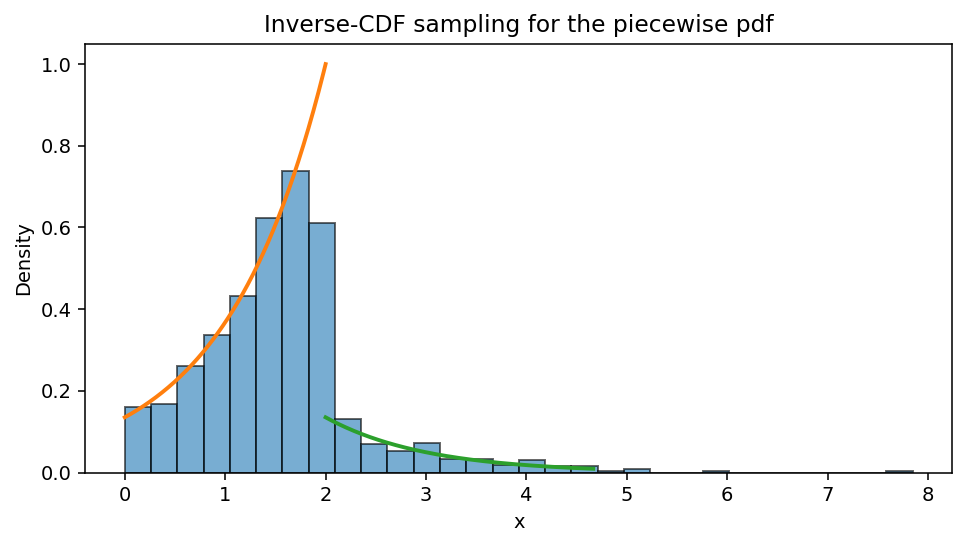

Cut probability 1 - e^(-2) = 0.864665
Fraction of samples in [0,2]: 0.858


In [7]:
cut = 1 - np.exp(-2) 

def sample_X(n, rng=np.random.default_rng(0)):
    U = rng.random(n)
    X = np.empty(n)
    m = (U <= cut)
    X[m]  = 2 + np.log(U[m] + np.exp(-2))  
    X[~m] = -np.log(1 - U[~m])           
    return X

# Generate 1,000 samples
rng = np.random.default_rng(123)
x = sample_X(1000, rng)

# Plot histogram and overlay the true pdf
xs1 = np.linspace(0, 2, 200)
xs2 = np.linspace(2, np.percentile(x, 99.5), 200)

plt.figure(figsize=(7,4), dpi=140)
plt.hist(x, bins=30, density=True, edgecolor="black", alpha=0.6)
plt.plot(xs1, np.exp(xs1-2), linewidth=2) 
plt.plot(xs2, np.exp(-xs2),  linewidth=2) 
plt.xlabel("x"); plt.ylabel("Density")
plt.title("Inverse-CDF sampling for the piecewise pdf")
plt.tight_layout()
plt.show()

# Quick checks
print(f"Cut probability 1 - e^(-2) = {cut:.6f}")
print(f"Fraction of samples in [0,2]: {(x<=2).mean():.3f}")


<hr><hr>

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

<hr>

**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

<hr>

### Ans.


In [8]:
def f(x):
    return (5*x**4 + 4*x**3 + 3*x**2 + 1) / 4

def sample_generator(n_samples):
    c = 3.25
    samples = []
    while len(samples) < n_samples:
        x = np.random.rand() 
        u = np.random.rand() * c
        if u <= f(x):
            samples.append(x)
    return np.array(samples)

<hr>

**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?

<hr>

### Ans.
For the acceptance--rejection method, we need a constant $c > 0$ such that $f(x) \leq c g(x), \forall x \in [0,1].$
Since $g(x) = 1$, this reduces to $f(x) \leq c, \quad \forall x \in [0,1].$
Thus, $c = \max_{x \in [0,1]} f(x) = f(1) = 3.25.$



The acceptance probability is
$p = \frac{1}{c} \int_0^1 f(x) \, dx.$

Since $f(x)$ is a probability density function, $\int_0^1 f(x) \, dx = 1.$
Thus,$p = \frac{1}{c} = \frac{1}{3.25} \approx 0.3077.$

Therefore, the expected number of proposals per accepted sample is $\mathbb{E}[N] = \frac{1}{p} = c = 3.25.$
Hence, on average, about $3.25$ uniform draws are needed to obtain one accepted sample.

<hr>

**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.

<hr>

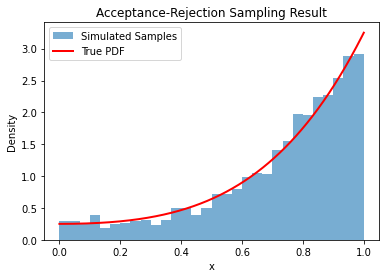

In [9]:
sample_X = sample_generator(2500)

x = np.linspace(0, 1, 500)
plt.hist(sample_X, bins=30, density=True, alpha=0.6, label="Simulated Samples")
plt.plot(x, f(x), 'r-', linewidth=2, label="True PDF")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Acceptance-Rejection Sampling Result")
plt.show()

<hr><hr>

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a $\mathcal{N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

<hr>

**(a)** First, suppose we choose the proposal distribution to be a $\emph{Laplace}$ (i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.

<hr>

The proposal distribution is Laplace(0,1) with pdf: $g(x) = \tfrac{1}{2} e^{-|x|}.$

Its CDF is:
$$G(x) = 
\begin{cases}
\tfrac{1}{2} e^x, & x < 0, \\
1 - \tfrac{1}{2} e^{-x}, & x \geq 0.
\end{cases}$$

To invert: if $U \sim U[0,1]$, then
$$X = 
\begin{cases}
\ln(2U), & U < \tfrac{1}{2}, \\
-\ln(2(1-U)), & U \geq \tfrac{1}{2}.
\end{cases}$$

In [10]:
def sample_laplace(n):
    U = np.random.rand(n)
    X = np.where(U < 0.5, np.log(2*U), -np.log(2*(1-U)))
    return X

<hr>

**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in\mathbb{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim\mathcal{N}(0,1)$, and compute the expected number of samples needed for generating each sample.

<hr>

### Ans.
We want $k g(x) \geq f(x)$ for all $x \in \mathbb{R}$. Equivalently, $k \geq \sup_{x \in \mathbb{R}} \frac{f(x)}{g(x)}.$

The ratio is
$$R(x) = \frac{f(x)}{g(x)} = \frac{\frac{1}{\sqrt{2\pi}} e^{-x^2/2}}{\tfrac{1}{2} e^{-|x|}}
= \sqrt{\frac{2}{\pi}} \, e^{-x^2/2 + |x|}.$$

For $x \geq 0$,
$$R(x) = \sqrt{\frac{2}{\pi}} \, e^{-x^2/2 + x}.$$

$$R^\prime(x)=\sqrt{\frac{2}{\pi}}(-x+1)$$
Set $R^\prime(x)=0$, $R(x)$ get maximized at $x=1$. Thus
$R_{min}(x)= R(1) = \sqrt{\frac{2}{\pi}} e^{1/2}.$

Numerically,
$$k = \sqrt{\frac{2}{\pi}} e^{1/2} \approx 1.315.$$

Hence the expected number of samples per acceptance is about $1.315$.


In [11]:
def sample_normal_via_laplace(n):
    k = np.sqrt(2/np.pi) * np.exp(0.5) 
    samples = []
    total_uniforms = 0
    
    while len(samples) < n:
        Y = sample_laplace(1)[0]
        U = np.random.rand()
        total_uniforms += 2 
        if U <= (np.exp(-Y**2/2) / np.sqrt(2*np.pi)) / (k * (0.5*np.exp(-abs(Y)))):
            samples.append(Y)
    
    return np.array(samples), total_uniforms

<hr>

**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.

<hr>

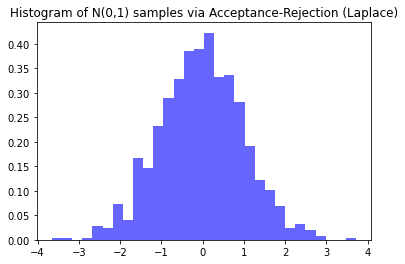

Mean total uniforms: 2,629.42
95% CI total uniforms: (2,625.68, 2,633.17)


In [12]:
samples, total_uniforms = sample_normal_via_laplace(1000)

plt.hist(samples, bins=30, density=True, alpha=0.6, color='blue')
plt.title("Histogram of N(0,1) samples via Acceptance-Rejection (Laplace)")
plt.show()


def replications(R=500, n=1000, func=None):
    totals = np.empty(R, dtype=float)
    for r in range(R):
        samples, total_uniforms = func(n)
        totals[r] = total_uniforms

    mean_total = totals.mean()
    se_total = totals.std(ddof=1) / np.sqrt(R)
    ci_total = (mean_total - 1.96*se_total, mean_total + 1.96*se_total)

    print(f"Mean total uniforms: {mean_total:,.2f}")
    print(f"95% CI total uniforms: ({ci_total[0]:,.2f}, {ci_total[1]:,.2f})")

replications(R=500, n=1000, func=sample_normal_via_laplace)

<hr>

**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.

<hr>

For Cauchy $(0,1)$: $g(x) = \frac{1}{\pi(1+x^2)}.$

Its CDF is $G(x) = \tfrac{1}{\pi} \arctan(x) + \tfrac{1}{2}.$

By inversion: if $U \sim U[0,1]$, $X = \tan\big(\pi(U - 0.5)\big).$

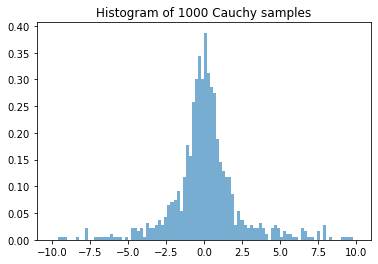

In [13]:
def sample_cauchy(n):
    U = np.random.rand(n)
    return np.tan(np.pi * (U - 0.5))

plt.hist(sample_cauchy(1000), bins=100, range=(-10,10), alpha=0.6, density=True)
plt.title("Histogram of 1000 Cauchy samples")
plt.show()

<hr>

**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.

<hr>

### Ans.

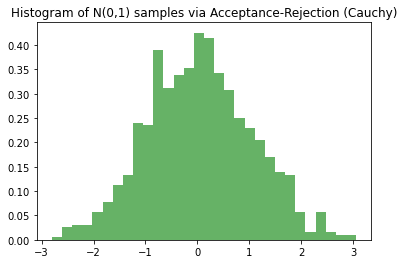

Mean total uniforms: 3,045.51
95% CI total uniforms: (3,040.65, 3,050.37)


In [14]:
def sample_normal_via_cauchy(n):
    k = np.sqrt(np.pi/2) * 2 * np.exp(-0.5)  # ~1.315
    samples = []
    total_uniforms = 0
    
    while len(samples) < n:
        Y = sample_cauchy(1)[0]
        U = np.random.rand()
        total_uniforms += 2  # one for inversion, one for rejection
        if U <= (np.exp(-Y**2/2) / np.sqrt(2*np.pi)) / (k * (1/(np.pi*(1+Y**2)))):
            samples.append(Y)
    
    return np.array(samples), total_uniforms

samples_cauchy, total_uniforms_cauchy = sample_normal_via_cauchy(1000)

plt.hist(samples_cauchy, bins=30, density=True, alpha=0.6, color='green')
plt.title("Histogram of N(0,1) samples via Acceptance-Rejection (Cauchy)")
plt.show()

replications(R=500, n=1000, func=sample_normal_via_cauchy)